In [192]:
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
from pycocotools.coco import COCO
from pycocotools.coco import maskUtils


import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
import pylab
import os
import json
import pandas as pd
import sys

from tqdm import tqdm_notebook as tqdm
tqdm().pandas()

pylab.rcParams['figure.figsize'] = (10.0, 8.0)

### Create a COCO-formatted File for Fashion Data
The maskrnn library can be best used with a COCO object.  This object manages your images and categories for training.  Daata provied by the Fashion challenge is combined to create a single JSON file that holds data in the format used by the COCO object.

Mask rcnn library: <br>
https://github.com/matterport/Mask_RCNN/tree/3deaec5d902d16e1daf56b62d5971d428dc920bc

COCO format: <br>
http://cocodataset.org/#format-data



Fashion files used to create COCO-formatted file:  `train.csc` and `label_descriptions.json`.

A file names `fashion_dictionary.json` will be created in the data source directory when this notebook is executed.

The file is a json file with 5 dictionary entries:<br>

**`info`** - basic info about the file<br>


**`licenses`** - licenses used in the images<br>


**`images`** - a list of dictionaries where each list item is an image
        the dictionary in each list element:<br>
        `license` - the respective license number from the 'license' entry<br>
        `file_name` - name of the file<br>
        `height` - height dimenstion of image<br>
        `width` - width dimenstion of the image<br>
        `id` - id of the image (same as filename without the extension)<br>
        
     
**`annotations`** - list of segmented images in all of the the files. <br>
        `segmentation` - segmentation coordinates<br>
        `area` - <br>
        `iscrowd` - <br>
        `image_id` - respective image id from 'images' entry<br>
        `bbox` - 4 x.y coordinates indicating the bounding box<br>
        `category_id` - respective category id from 'category' entry<br>
        `id` - id of the annotation<br>
        
**`categories`** - list of cateogries in all the images<br>
        `supercateogry` - <br>
        `id` - id if the category<br>
        `name` - name of the category<br>

In [24]:
annotations_dir = '../../data/FashionDataSet/libraries/annotations'
coco_data_dir = ''
dataType='train2017'
annFile=os.path.join(annotations_dir, 'instances_{}.json'.format(dataType))


In [15]:
data_dir='../../data/FashionDataSet/'
fashFile=os.path.join(data_dir, 'fashion_dictionary.json')

In [211]:
def convert_rle(rle:str, height:int=0, width:int=0) -> dict:
    """
    Converts the fashion data set RLE format,
    to the COCO dataset format
    """
    rv = {'counts':[], 'size':[(height,width)]}
    counts = rv.get('counts')
    
    #tokenize
    tokens = rle.split(' ')
    num_tokens = len(tokens)
    
    counts.extend([int(x) for x in tokens])
    
    return rv

In [212]:
def create_images(images_file:str) -> (dict, pd.DataFrame):
    
    df_images = pd.read_csv(images_file)
    df_images = df_images.drop(['EncodedPixels', 'ClassId'], axis=1).drop_duplicates()
    df_images.rename(columns={"ImageId":'file_name', "Height":'height', "Width":'width'}, inplace=True)
    df_images['id'] = [x for x in range(len(df_images))]
    
    dict_images = [dict(x[1]) for x in tqdm(df_images.iterrows(), desc="Images Dict", total=len(df_images))]
    
    return dict_images, df_images


In [213]:
def create_info() -> dict:
    
    info_dict = {'year': 2019,
                 'version': '1.0',
                 'description': 'The 2019 FGVC^6 iMaterialist Competition - Fashion track dataset.',
                 'contributor': 'iMaterialist Fashion Competition group',
                 'url': 'https://github.com/visipedia/imat_comp',
                 'date_created': '2019-04-19 12:38:27.493919'}
    
    return info_dict

In [214]:
def create_licenses() -> list:
    
    licenses_list = [{'id':0, 'url':'', 'name':''}]
    
    return licenses_list

In [215]:
def create_categories(cat_file:str) -> dict:
    # read labels file
    with open(cat_file, 'r') as data_file:
        data=data_file.read()

    # parse file
    labels = json.loads(data)
    
    categories = labels.get('categories')
    df_categories = pd.DataFrame(categories)

    dict_categories = [dict(x[1]) for x in df_categories.iterrows()]
    
    return dict_categories

In [216]:
def create_annotations(images_file:str, images:pd.DataFrame) -> dict:
    
    df_images = pd.read_csv(images_file)
    df_images = df_images.drop(['Height', 'Width'], axis=1)
    df_images.rename(columns={"ImageId":'image_id', "ClassId":'category_id', "EncodedPixels":'segmentation'}, inplace=True)
#     df_images['id'] = [images[images.file_name==x]['id'] for x in tqdm(df_images['image_id'])]
    
    dict_annotations = [(dict({"id":x[0], 
                               "image_id":int(images[images.file_name==x[1].image_id]['id'].values[0]),
#                                "image_id":x[1].id,
                               "segmentation":  convert_rle(x[1].segmentation,
                                                            height=int(images[images.file_name==x[1].image_id]['height'].values[0]),
                                                            width=int(int(images[images.file_name==x[1].image_id]['width'].values[0]))),
                               "category_id":int(x[1].category_id.split('_')[0]),
                               "area": None,
                               "iscrowd": None,
                               "bbox": None})) for x in tqdm(df_images.iterrows(), desc="Annotations Dict", total=len(df_images))]

    return dict_annotations

In [217]:
# images_file = os.path.join(data_dir, 'train.csv' )
# dict_images, df_images = create_images(images_file)
# annots = create_annotations(images_file, df_images)

In [218]:
def create_coco_json(data_dir:str, output_file:str=fashFile):
    """
    Creates a json file in COCO format for the Fashion dataset
    """
    # Create the "info" dictionary entry
    info = create_info()
    
    # Create the "licenses" dictionary entry
    licenses = create_licenses()
    
    # Create the "images" dictionary entry
    images_file = os.path.join(data_dir, 'train.csv' )
    images, df_images = create_images(images_file)
    
    # Create the "annotations" dictionary entry
    images_file = os.path.join(data_dir, 'train.csv' )
    annotations = create_annotations(images_file, df_images)
    
    # Create the "categories" dictionary entry 
    cat_file = os.path.join(data_dir, 'label_descriptions.json' )
    categories = create_categories(cat_file)
    
    # Create the dictionary
    coco_dict = {'info':info, 
                 'licenses':licenses, 
                 'images':images,
                 'annotations':annotations,
                 'categories':categories}
    
    # Save dictionary as JSON file
    json_file = json.dumps(coco_dict)
    fp = open(output_file, 'w')
    
    fp.write(json_file)
    fp.close()
    
    pwd = !pwd
    
    print("File saved to: {}/{}".format(pwd, output_file))
    
    return output_file
    
    

In [ ]:
# Create the COCO formatted JSON file - takes ~30 minutes
fashFile = create_coco_json(data_dir)

### Read COCO and Fashion Annotation Files
These will be compared to ensure the Fashion file works as expected

In [92]:
# read COCO annotaions file
with open(annFile, 'r') as myfile:
    data=myfile.read()
ann_labels = json.loads(data)

# read fashion_dicionary.json
with open(fashFile, 'r') as myfile:
    data=myfile.read()
fash_labels = json.loads(data)

In [95]:
# Check keys
print("COCO Labels   :",ann_labels.keys())
print("Fashion Labels:",fash_labels.keys())

COCO Labels   : dict_keys(['info', 'licenses', 'images', 'annotations', 'categories'])
Fashion Labels: dict_keys(['info', 'licenses', 'images', 'annotations', 'categories'])


In [96]:
# Check the Values for each key - store each value separately
ann_ann = ann_labels.get('annotations')
fash_ann = fash_labels.get('annotations')
ann_cats = ann_labels.get('categories')
fash_cats = fash_labels.get('categories')
ann_images = ann_labels.get('images')
fash_images = fash_labels.get('images')

In [97]:
# COCO uses x.y coordinates for masks - but also supports RLE
ann_ann[0].get('segmentation')

[[239.97,
  260.24,
  222.04,
  270.49,
  199.84,
  253.41,
  213.5,
  227.79,
  259.62,
  200.46,
  274.13,
  202.17,
  277.55,
  210.71,
  249.37,
  253.41,
  237.41,
  264.51,
  242.54,
  261.95,
  228.87,
  271.34]]

In [105]:
fash_ann[0].keys()

dict_keys(['id', 'image_id', 'segmentation', 'category_id', 'area', 'iscrowd', 'bbox'])

In [209]:
# The Fashion annotation file uses RLE
fash_ann[0].get('segmentation').get('counts')

[[6068157,
  7,
  6073371,
  20,
  6078584,
  34,
  6083797,
  48,
  6089010,
  62,
  6094223,
  72,
  6099436,
  76,
  6104649,
  80,
  6109862,
  85,
  6115075,
  89,
  6120288,
  93,
  6125501,
  98,
  6130714,
  102,
  6135927,
  106,
  6141140,
  111,
  6146354,
  114,
  6151567,
  118,
  6156780,
  123,
  6161993,
  127,
  6167206,
  131,
  6172419,
  136,
  6177632,
  140,
  6182845,
  144,
  6188058,
  149,
  6193271,
  153,
  6198484,
  157,
  6203697,
  162,
  6208910,
  166,
  6214124,
  169,
  6219337,
  174,
  6224550,
  178,
  6229763,
  182,
  6234976,
  187,
  6240189,
  191,
  6245402,
  195,
  6250615,
  200,
  6255828,
  204,
  6261041,
  208,
  6266254,
  213,
  6271467,
  218,
  6276680,
  224,
  6281893,
  229,
  6287107,
  233,
  6292320,
  238,
  6297533,
  244,
  6302746,
  249,
  6307959,
  254,
  6313172,
  259,
  6318385,
  265,
  6323598,
  270,
  6328811,
  275,
  6334024,
  280,
  6339237,
  286,
  6344450,
  291,
  6349663,
  296,
  6354877,
  300,
  636

In [208]:
maskUtils.area(fash_ann[0].get('segmentation').get('counts'))

TypeError: list indices must be integers or slices, not str

In [107]:
ann_cats[0].keys()

dict_keys(['supercategory', 'id', 'name'])

In [108]:
fash_cats[0].keys()

dict_keys(['id', 'level', 'name', 'supercategory'])

In [110]:
fash_cats[1]

{'id': 1,
 'level': 2,
 'name': 'top, t-shirt, sweatshirt',
 'supercategory': 'upperbody'}

### Create COCO objects from each file
From the JSON file, a COCO object is created that can be used in training.
The object suports various utility functions that allow database-like 
review and handling of the elements in the data set.
Other utukuty functions handle the display of images with and without masks.

In [182]:
# The following API functions are defined:
# https://github.com/cocodataset/cocoapi/blob/master/PythonAPI/pycocotools/coco.py
#  COCO       - COCO api class that loads COCO annotation file and prepare data structures.
#  decodeMask - Decode binary mask M encoded via run-length encoding.
#  encodeMask - Encode binary mask M using run-length encoding.
#  getAnnIds  - Get ann ids that satisfy given filter conditions.
#  getCatIds  - Get cat ids that satisfy given filter conditions.
#  getImgIds  - Get img ids that satisfy given filter conditions.
#  loadAnns   - Load anns with the specified ids.
#  loadCats   - Load cats with the specified ids.
#  loadImgs   - Load imgs with the specified ids.
#  annToMask  - Convert segmentation in an annotation to binary mask.
#  showAnns   - Display the specified annotations.
#  loadRes    - Load algorithm results and create API for accessing them.
#  download   - Download COCO images from mscoco.org server.

In [ ]:
# MASK API
# https://github.com/cocodataset/cocoapi/blob/master/PythonAPI/pycocotools/mask.py
# The following API functions are defined:
#  encode         - Encode binary masks using RLE.
#  decode         - Decode binary masks encoded via RLE.
#  merge          - Compute union or intersection of encoded masks.
#  iou            - Compute intersection over union between masks.
#  area           - Compute area of encoded masks.
#  toBbox         - Get bounding boxes surrounding encoded masks.
#  frPyObjects    - Convert polygon, bbox, and uncompressed RLE to encoded RLE mask.
#
# Usage:
#  Rs     = encode( masks )
#  masks  = decode( Rs )
#  R      = merge( Rs, intersect=false )
#  o      = iou( dt, gt, iscrowd )
#  a      = area( Rs )
#  bbs    = toBbox( Rs )
#  Rs     = frPyObjects( [pyObjects], h, w )
#
# In the API the following formats are used:
#  Rs      - [dict] Run-length encoding of binary masks
#  R       - dict Run-length encoding of binary mask
#  masks   - [hxwxn] Binary mask(s) (must have type np.ndarray(dtype=uint8) in column-major order)
#  iscrowd - [nx1] list of np.ndarray. 1 indicates corresponding gt image has crowd region to ignore
#  bbs     - [nx4] Bounding box(es) stored as [x y w h]
#  poly    - Polygon stored as [[x1 y1 x2 y2...],[x1 y1 ...],...] (2D list)
#  dt,gt   - May be either bounding boxes or encoded masks
# Both poly and bbs are 0-indexed (bbox=[0 0 1 1] encloses first pixel).

In [112]:
# initialize COCO api for instance annotations
coco=COCO(annFile)
fash=COCO(fashFile)

loading annotations into memory...
Done (t=36.72s)
creating index...
index created!
loading annotations into memory...
Done (t=110.31s)
creating index...
index created!


### Categories

In [116]:
# COCO
# display COCO categories and supercategories
cats = coco.loadCats(coco.getCatIds())
nms=[cat['name'] for cat in cats]
print ('COCO categories: \n\n', ' '.join(nms))

nms = set([cat['supercategory'] for cat in cats])
print ('COCO supercategories: \n', ' '.join(nms))

COCO categories: 

 person bicycle car motorcycle airplane bus train truck boat traffic light fire hydrant stop sign parking meter bench bird cat dog horse sheep cow elephant bear zebra giraffe backpack umbrella handbag tie suitcase frisbee skis snowboard sports ball kite baseball bat baseball glove skateboard surfboard tennis racket bottle wine glass cup fork knife spoon bowl banana apple sandwich orange broccoli carrot hot dog pizza donut cake chair couch potted plant bed dining table toilet tv laptop mouse remote keyboard cell phone microwave oven toaster sink refrigerator book clock vase scissors teddy bear hair drier toothbrush
COCO supercategories: 
 electronic appliance outdoor accessory sports vehicle kitchen person food animal indoor furniture


In [117]:
# FASHION
# display COCO categories and supercategories
cats = fash.loadCats(fash.getCatIds())
nms=[cat['name'] for cat in cats]
print ('FASH categories: \n\n', ' '.join(nms))

nms = set([cat['supercategory'] for cat in cats])
print ('FASH supercategories: \n', ' '.join(nms))

FASH categories: 

 shirt, blouse top, t-shirt, sweatshirt sweater cardigan jacket vest pants shorts skirt coat dress jumpsuit cape glasses hat headband, head covering, hair accessory tie glove watch belt leg warmer tights, stockings sock shoe bag, wallet scarf umbrella hood collar lapel epaulette sleeve pocket neckline buckle zipper applique bead bow flower fringe ribbon rivet ruffle sequin tassel
FASH supercategories: 
 arms and hands waist neck legs and feet others head garment parts upperbody wholebody decorations closures lowerbody


### Images

In [150]:
# COCO
# get all images containing given categories, select one at random
catIds = coco.getCatIds(catNms=['person','dog','skateboard']);
imgIds = coco.getImgIds(catIds=catIds);
img = coco.loadImgs(imgIds[np.random.randint(0,len(imgIds))])[0]

In [151]:
img

{'license': 3,
 'file_name': '000000172310.jpg',
 'coco_url': 'http://images.cocodataset.org/train2017/000000172310.jpg',
 'height': 480,
 'width': 640,
 'date_captured': '2013-11-18 10:55:59',
 'flickr_url': 'http://farm4.staticflickr.com/3567/4566789533_a39eac2e23_z.jpg',
 'id': 172310}

In [152]:
img.get('coco_url')

'http://images.cocodataset.org/train2017/000000172310.jpg'

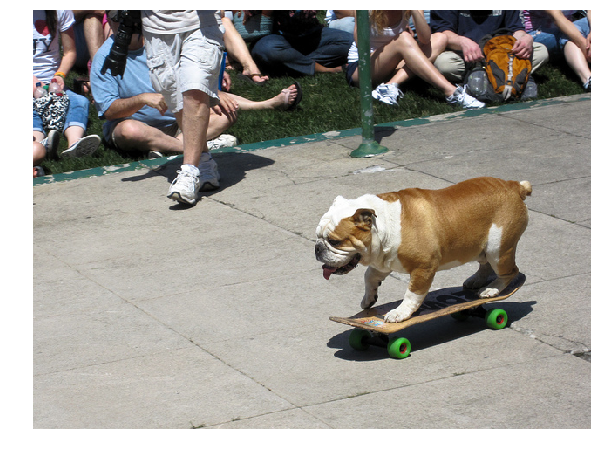

In [153]:
# load and display image
# I = io.imread(os.path.join(dataDir, 'images', dataType, img['file_name']))
# I = io.imread('%s/images/%s/%s'%(dataDir,dataType,img['file_name']))
# use url to load image
# I = io.imread('http://mscoco.org/images/%d'%(img['id']))
I = io.imread(img.get('coco_url'))
plt.figure(); plt.axis('off')
plt.imshow(I)
plt.show()

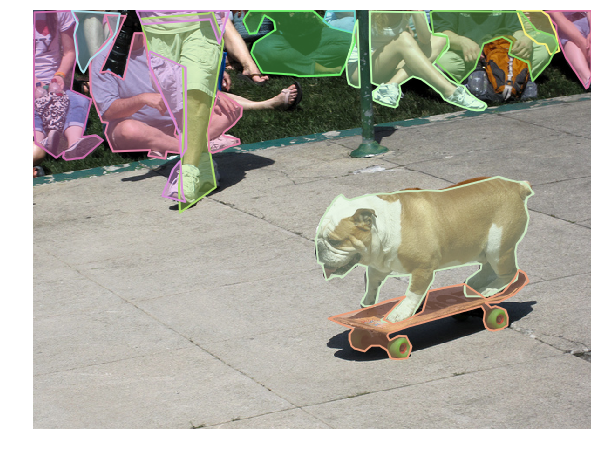

In [154]:
# load and display instance annotations
plt.imshow(I); plt.axis('off')
annIds = coco.getAnnIds(imgIds=img['id'], catIds=catIds, iscrowd=None)
anns = coco.loadAnns(annIds)
coco.showAnns(anns)

In [157]:
len(anns)

13

In [160]:
anns[0].keys()

dict_keys(['segmentation', 'area', 'iscrowd', 'image_id', 'bbox', 'category_id', 'id'])

In [162]:
anns[0]['segmentation']

[[337.06,
  230.0,
  338.03,
  227.1,
  340.93,
  223.24,
  343.82,
  218.41,
  348.65,
  213.58,
  353.48,
  210.68,
  357.34,
  215.51,
  363.14,
  217.44,
  367.97,
  215.51,
  379.56,
  212.61,
  383.42,
  211.65,
  397.91,
  209.72,
  409.5,
  209.72,
  418.19,
  207.78,
  428.81,
  206.82,
  440.4,
  206.82,
  450.06,
  205.85,
  467.44,
  206.82,
  476.14,
  204.89,
  499.32,
  199.09,
  533.12,
  190.4,
  542.78,
  193.3,
  554.37,
  196.19,
  560.16,
  196.19,
  566.92,
  200.06,
  573.68,
  209.72,
  565.96,
  214.54,
  564.02,
  223.24,
  567.89,
  237.72,
  564.02,
  254.14,
  560.16,
  260.9,
  554.37,
  267.66,
  552.43,
  276.36,
  554.37,
  293.74,
  556.3,
  295.67,
  554.37,
  308.23,
  536.98,
  318.85,
  526.36,
  324.65,
  516.7,
  327.54,
  496.42,
  327.54,
  494.49,
  322.71,
  494.49,
  315.95,
  497.38,
  308.23,
  512.84,
  296.64,
  513.8,
  290.84,
  509.94,
  289.88,
  495.45,
  291.81,
  479.03,
  294.71,
  459.72,
  298.57,
  458.75,
  308.23,
  438.47,


In [163]:
anns[0]['area']

25059.38285000001

In [168]:
anns[0]['iscrowd']

0

In [164]:
anns[0]['image_id']

172310

In [165]:
anns[0]['bbox']

[323.54, 190.4, 250.14, 168.05]

In [166]:
anns[0]['category_id']

18

In [167]:
anns[0]['id']

7954

In [169]:
# FASHION
# get all images containing given categories, select one at random
# catIds = fash.getCatIds(catNms=['sweater','jacket','purse']);
catIds = fash.getCatIds();
imgIds = fash.getImgIds()   #(catIds=catIds);
img = fash.loadImgs(imgIds[np.random.randint(0,len(imgIds))]  )[0]

In [170]:
img

{'file_name': '70a116e03e361b85be5140d5e39ad2b0.jpg',
 'height': 1500,
 'width': 1000,
 'id': 20092}

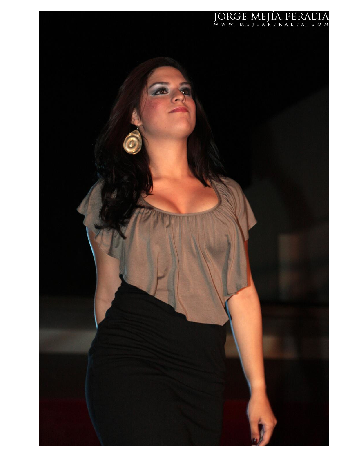

In [171]:
# load and display image
I = io.imread(os.path.join(data_dir, 'train', img.get('file_name')))
plt.figure(); plt.axis('off')
plt.imshow(I)
plt.show()

In [172]:
fash.getAnnIds(imgIds=img['id'])

[146572, 146573, 146574, 146575, 146576]

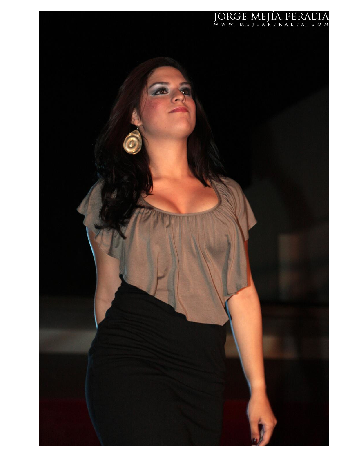

In [173]:
# load and display instance annotations
plt.imshow(I); plt.axis('off')
annIds = fash.getAnnIds(imgIds=img['id'])
anns = fash.loadAnns(annIds)
# fash.showAnns(anns)

In [158]:
len(anns)

13

In [174]:
anns[0].keys()

dict_keys(['id', 'image_id', 'segmentation', 'category_id', 'area', 'iscrowd', 'bbox'])

In [175]:
anns[0]['segmentation']

{'counts': [[235318,
   8,
   236807,
   24,
   238295,
   40,
   239784,
   56,
   241272,
   72,
   242761,
   88,
   244251,
   102,
   245744,
   114,
   247237,
   125,
   248729,
   138,
   250174,
   6,
   250222,
   149,
   251672,
   17,
   251715,
   161,
   253170,
   29,
   253208,
   171,
   254668,
   215,
   256166,
   220,
   257664,
   225,
   259162,
   230,
   260661,
   234,
   262159,
   240,
   263657,
   245,
   265155,
   250,
   266653,
   255,
   268151,
   260,
   269649,
   265,
   271147,
   271,
   272645,
   276,
   274143,
   281,
   275641,
   286,
   277139,
   291,
   278637,
   296,
   280135,
   302,
   281634,
   306,
   283132,
   311,
   284630,
   316,
   286128,
   321,
   287626,
   326,
   289124,
   330,
   290621,
   335,
   292116,
   342,
   293612,
   348,
   295108,
   354,
   296604,
   360,
   298099,
   367,
   299595,
   373,
   301092,
   378,
   302589,
   382,
   304086,
   387,
   305583,
   392,
   307081,
   396,
   308580,
  

In [176]:
anns[0]['area']

In [177]:
anns[0]['iscrowd']

In [178]:
anns[0]['image_id']

20092

In [179]:
anns[0]['bbox']

In [180]:
anns[0]['category_id']

'8_14_20_33_60_61_87'

In [181]:
anns[0]['id']

146572

In [10]:
# initialize COCO api for person keypoints annotations
annFile = '%s/annotations/person_keypoints_%s.json'%(dataDir,dataType)
coco_kps=COCO(annFile)

loading annotations into memory...
Done (t=13.65s)
creating index...
index created!


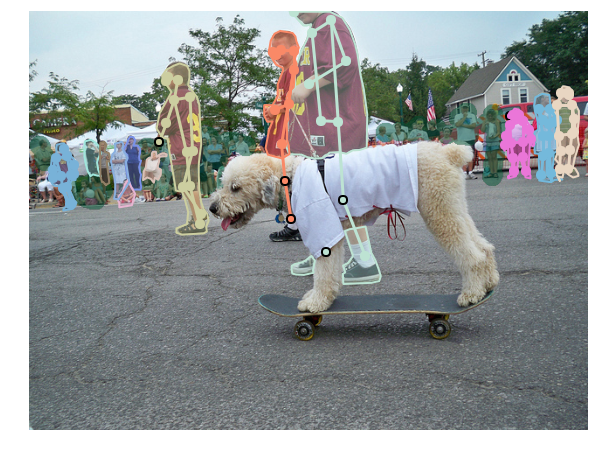

In [11]:
# load and display keypoints annotations
plt.imshow(I); plt.axis('off')
ax = plt.gca()
annIds = coco_kps.getAnnIds(imgIds=img['id'], catIds=catIds, iscrowd=None)
anns = coco_kps.loadAnns(annIds)
coco_kps.showAnns(anns)

In [12]:
# initialize COCO api for caption annotations
annFile = '%s/annotations/captions_%s.json'%(dataDir,dataType)
coco_caps=COCO(annFile)

loading annotations into memory...
Done (t=4.08s)
creating index...
index created!


A small brown dog wearing a white shirt on top of a skateboard.
A dog wearing a t-shirt while riding on a skateboard.
Dog on skateboard wearing t-shirt during parade event.
A large poodle takes part in a parade by riding a skateboard.
A dog is on a leash while riding on a skateboard.  


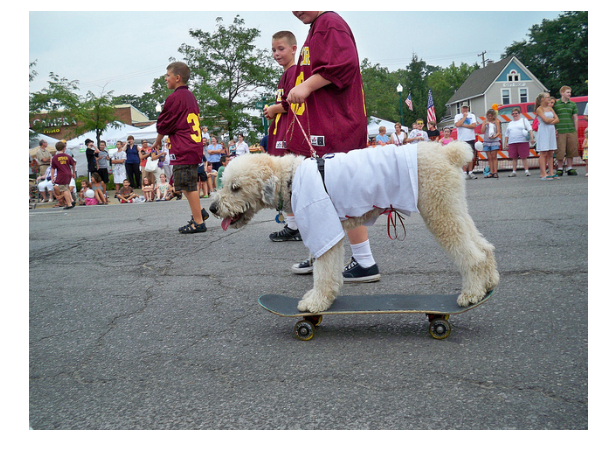

In [13]:
# load and display caption annotations
annIds = coco_caps.getAnnIds(imgIds=img['id']);
anns = coco_caps.loadAnns(annIds)
coco_caps.showAnns(anns)
plt.imshow(I); plt.axis('off')
plt.show()